read clusterd song data and use NLP algorithms to help generate topics (Playlist Name) for each cluster. 

# Import Data

In [1]:
import pandas as pd
songData = pd.read_csv('songDataKProto.csv')

In [2]:
groupby = songData.groupby('kproto')

In [3]:
#get a list of cluster lables sorted
kprotoLabels = sorted(list(songData['kproto'].unique()))
songDict = {}

#make a dictionary with key = label, value = all song names fit into one string
for i in kprotoLabels:
    songDict[i] = groupby.get_group(i).songName.str.cat(sep=' ')

In [4]:
#songDict

In [5]:
songStringDF = pd.DataFrame.from_dict(songDict, orient='index')

In [6]:
songStringDF.columns=['songNamesString']

Corpus (one body of text for each cluster)

In [ ]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 1000)

In [30]:
songStringDF.columns

Index(['songNamesString'], dtype='object')

# Clean Data

Prep for document Term matrix.

Text cleaning involves importing RegularExpression library and string library.

In [8]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\([^)]*\)','',text)
    text = re.sub('\[.*?\]', '', text)#any number or word that contains a number
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

cleanText = lambda x: clean_text(x)

In [9]:
data_clean = pd.DataFrame(songStringDF.songNamesString.apply(cleanText))
#data_clean

Next create document Term matrix

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

#skip stop words from being included in the count
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.songNamesString)
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
data_dtm.index = data_clean.index
#data_dtm

# EDA

In [11]:
data_dtm

,aap,account,acoustic,action,addicted,addys,adorn,adventure,affection,africa,afrojack,aftergold,aint,aisha,alarm,alaska,album,alchemy,alike,alive,alley,alleyoop,alright,amber,america,american,animal,anonymous,answer,antidote,anymore,aoki,apathy,aplauda,appeals,aqueous,arcade,area,aries,ark,arms,art,artificial,ascension,ashley,atm,attack,attention,aura,ave,away,awhile,baby,bacc,backbone,backstage,backwards,bad,badder,baecation,bag,bagbak,baguetti,bailar,ball,balmain,bamba,bambi,bando,bands,bang,bank,banquet,banx,bartier,barz,base,battlefield,bay,bayo,beach,beamin,beasty,beat,beatles,beaucoup,bedtime,beep,behavior,beibs,bein,belgium,believe,ben,benny,berlin,berry,best,better,bibimbap,bid,bieber,big,bigbright,bigger,bikers,birds,bitch,bizarre,black,blacker,blackjack,blame,blanco,blanguage,blast,blasé,blem,blessings,blinding,bling,blood,blooded,bloody,blow,blowback,blue,blur,boca,bodak,bodega,body,bonbon,bones,bong,bongo,bonus,boogie,boogieman,bop,bounce,bound,bout,box,boy,boys,bqe,brave,break,breakeven,breakfast,breaking,breath,breek,breezeblocks,bright,bring,broccoli,brooks,brother,brun,brxnks,btstu,bucket,buckets,buds,bulalay,bully,buscando,butter,butterflies,buzz,buzzcut,bye,byob,bystanders,ca,cabu,cactus,cadet,cadillac,caesar,calabasas,calabria,california,calling,calls,came,canal,canceled,candy,canoga,cappin,car,carat,cardi,cardigan,caroline,carousel,cartal,cartoon,cash,castro,cause,cc,ceiling,celebrity,cereal,cha,chains,chameleon,chance,chandelier,chanel,change,changin,changing,chanting,charlotte,chasers,chasing,check,checklist,cheerleader,chemistry,cherry,chest,chi,chief,child,chilis,chill,chimes,chips,chocolates,chopstix,christopher,chum,chun,cigarettes,circles,city,clean,climax,close,closer,clothes,clout,club,cold,colder,cole,collar,colors,colours,coma,come,comes,comfortable,coming,commandments,common,company,complaints,concrete,confessions,congratulations,connaissais,connection,constant,contigo,control,controlla,controllin,conversations,cookie,cool,cooler,copied,costa,cosurmyne,coul,coupe,crack,crash,crave,crawling,crazy,creeping,crickets,criminal,crooked,cruise,crush,crushed,crystals,crzy,culture,cup,cups,curve,cut,cute,cutmore,da,daddi,dads,dance,dancin,dancing,dandelions,danger,dangerous,dare,dark,darkest,dash,dashboard,dat,dawn,dawsins,day,days,daze,dazs,dazzle,dead,deadass,deadcrush,dealers,dearly,deez,delete,delicate,dem,demons,departed,design,desire,devastated,devil,diamonds,dick,did,diet,difference,digital,dillon,dip,diplomatic,dirt,dirty,dis,discoteque,discussion,disparate,distant,divide,divinity,dm,dna,dnmo,dog,dogs,doin,doing,dolce,dolla,don,dont,dopamine,dope,dopeboy,dopemang,dos,dot,double,douha,downtown,draco,drank,dre,dream,dreaming,dreams,driftig,drifting,drink,drinks,drip,dripped,drive,drivers,drivin,drop,drove,drug,druggys,drunk,dry,dub,dumb,dusty,dvb,dvision,dímelo,earned,ears,earth,earwulf,eddie,edit,edxs,efx,ego,electric,elo,elsies,em,end,endless,ends,enemy,energia,energy,enuff,es,esskeetit,eventually,everlong,everybody,everyday,excellence,exchange,extended,extra,eyes,eyez,face,fade,faded,fall,fallen,falling,falls,false,family,fantasy,fargo,fast,father,fault,favors,feat,features,february,feed,feel,feelin,feeling,feels,feet,felix,felt,female,ferreck,fires,fish,fisted,fk,fkj,flacko,flag,flair,flick,flip,float,floating,floor,flops,flosstradamus,flow,flume,fly,flying,foes,foldin,follow,ford,foreplay,forest,forever,forget,forgive,forgot,franchise,francis,frauds,freaking,freaky,...,rac,race,racks,radio,raf,rage,rager,rambo,ransom,ranx,rap,rapper,raps,rapstar,rare,rasputin,raton,raw,razzle,real,realer,realla,really,reborn,recipe,recorded,red,redbone,reedit,reel,reeves,reggie,regular,relapse,remaster,remastered,rembrandtrun,remi,remix,remote,renegades,repeat,restoration,retribution,retro,reverse,rewind,ric,rica,rice,rich,rico,ride,ridin,rigamortus,right,rings,ripstick,ritual,rivals,river,riviera,road,robin,rock,rocket,rockstar,role,roll,rollin,romantic,ronson,room,roses,roux,roxanne,rubbin,rubies,rum,run,run

In [12]:
#transpose df to make aggregation easier
data_dtm = data_dtm.transpose()
data_dtm

,0,1,2,3,4,5,6
aap,0,0,0,1,0,0,0
account,0,0,0,1,0,0,1
acoustic,1,0,0,0,1,0,0
action,0,0,0,1,0,0,0
addicted,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
zombies,0,0,1,0,0,0,0
zuki,0,0,0,0,1,0,0
zulu,0,0,0,0,0,0,1
zzzs,0,1,0,0,0,0,0


In [13]:
#Find top words in each playlist
top_words_dict = {}
for cluster in data_dtm.columns:
    top = data_dtm[cluster].sort_values(ascending=False).head(10)
    top_words_dict[cluster] = list(zip(top.index,top.values))
    
top_words_dict

{0: [('remix', 13),
  ('love', 11),
  ('like', 5),
  ('know', 3),
  ('water', 3),
  ('time', 3),
  ('way', 3),
  ('spotify', 3),
  ('man', 3),
  ('need', 3)],
 1: [('remix', 27),
  ('love', 5),
  ('time', 4),
  ('know', 4),
  ('right', 4),
  ('mix', 4),
  ('like', 4),
  ('original', 3),
  ('kids', 3),
  ('just', 3)],
 2: [('remix', 10),
  ('love', 4),
  ('lonely', 2),
  ('edit', 2),
  ('im', 2),
  ('look', 2),
  ('sad', 2),
  ('pink', 2),
  ('rare', 2),
  ('medasin', 2)],
 3: [('remix', 7),
  ('know', 7),
  ('got', 5),
  ('im', 5),
  ('good', 4),
  ('bad', 4),
  ('sleep', 3),
  ('come', 3),
  ('gang', 3),
  ('lucky', 3)],
 4: [('remix', 7),
  ('love', 5),
  ('high', 3),
  ('like', 3),
  ('night', 3),
  ('roux', 2),
  ('window', 2),
  ('attention', 2),
  ('water', 2),
  ('indica', 2)],
 5: [('walk', 4),
  ('track', 3),
  ('bonus', 3),
  ('got', 3),
  ('nigga', 3),
  ('right', 3),
  ('bitch', 3),
  ('remix', 3),
  ('talk', 3),
  ('money', 2)],
 6: [('remix', 23),
  ('feel', 4),
  ('radio

In [14]:
from collections import Counter

words = []
for pl in data_dtm.columns:
    top = [word for (word,count) in top_words_dict[pl]]
    for t in top:
        words.append(t)

#find common words         
words
Counter(words).most_common()

[('remix', 7),
 ('love', 5),
 ('like', 3),
 ('know', 3),
 ('water', 2),
 ('time', 2),
 ('man', 2),
 ('right', 2),
 ('edit', 2),
 ('im', 2),
 ('got', 2),
 ('way', 1),
 ('spotify', 1),
 ('need', 1),
 ('mix', 1),
 ('original', 1),
 ('kids', 1),
 ('just', 1),
 ('lonely', 1),
 ('look', 1),
 ('sad', 1),
 ('pink', 1),
 ('rare', 1),
 ('medasin', 1),
 ('good', 1),
 ('bad', 1),
 ('sleep', 1),
 ('come', 1),
 ('gang', 1),
 ('lucky', 1),
 ('high', 1),
 ('night', 1),
 ('roux', 1),
 ('window', 1),
 ('attention', 1),
 ('indica', 1),
 ('walk', 1),
 ('track', 1),
 ('bonus', 1),
 ('nigga', 1),
 ('bitch', 1),
 ('talk', 1),
 ('money', 1),
 ('feel', 1),
 ('radio', 1),
 ('mas', 1),
 ('sweet', 1),
 ('lights', 1),
 ('extended', 1)]

In [15]:
#find common words between the 7 playlists
add_stop_words = [word for word, count in Counter(words).most_common() if count > 5]
add_stop_words

['remix']

In [16]:
from sklearn.feature_extraction import text

#add 'remix' to the stop word list 
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

#reclean data with new stop word(s) removed
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.songNamesString)
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
data_dtm.index = data_clean.index


In [17]:
data_dtm

,aap,account,acoustic,action,addicted,addys,adorn,adventure,affection,africa,afrojack,aftergold,aint,aisha,alarm,alaska,album,alchemy,alike,alive,alley,alleyoop,alright,amber,america,american,animal,anonymous,answer,antidote,anymore,aoki,apathy,aplauda,appeals,aqueous,arcade,area,aries,ark,arms,art,artificial,ascension,ashley,atm,attack,attention,aura,ave,away,awhile,baby,bacc,backbone,backstage,backwards,bad,badder,baecation,bag,bagbak,baguetti,bailar,ball,balmain,bamba,bambi,bando,bands,bang,bank,banquet,banx,bartier,barz,base,battlefield,bay,bayo,beach,beamin,beasty,beat,beatles,beaucoup,bedtime,beep,behavior,beibs,bein,belgium,believe,ben,benny,berlin,berry,best,better,bibimbap,bid,bieber,big,bigbright,bigger,bikers,birds,bitch,bizarre,black,blacker,blackjack,blame,blanco,blanguage,blast,blasé,blem,blessings,blinding,bling,blood,blooded,bloody,blow,blowback,blue,blur,boca,bodak,bodega,body,bonbon,bones,bong,bongo,bonus,boogie,boogieman,bop,bounce,bound,bout,box,boy,boys,bqe,brave,break,breakeven,breakfast,breaking,breath,breek,breezeblocks,bright,bring,broccoli,brooks,brother,brun,brxnks,btstu,bucket,buckets,buds,bulalay,bully,buscando,butter,butterflies,buzz,buzzcut,bye,byob,bystanders,ca,cabu,cactus,cadet,cadillac,caesar,calabasas,calabria,california,calling,calls,came,canal,canceled,candy,canoga,cappin,car,carat,cardi,cardigan,caroline,carousel,cartal,cartoon,cash,castro,cause,cc,ceiling,celebrity,cereal,cha,chains,chameleon,chance,chandelier,chanel,change,changin,changing,chanting,charlotte,chasers,chasing,check,checklist,cheerleader,chemistry,cherry,chest,chi,chief,child,chilis,chill,chimes,chips,chocolates,chopstix,christopher,chum,chun,cigarettes,circles,city,clean,climax,close,closer,clothes,clout,club,cold,colder,cole,collar,colors,colours,coma,come,comes,comfortable,coming,commandments,common,company,complaints,concrete,confessions,congratulations,connaissais,connection,constant,contigo,control,controlla,controllin,conversations,cookie,cool,cooler,copied,costa,cosurmyne,coul,coupe,crack,crash,crave,crawling,crazy,creeping,crickets,criminal,crooked,cruise,crush,crushed,crystals,crzy,culture,cup,cups,curve,cut,cute,cutmore,da,daddi,dads,dance,dancin,dancing,dandelions,danger,dangerous,dare,dark,darkest,dash,dashboard,dat,dawn,dawsins,day,days,daze,dazs,dazzle,dead,deadass,deadcrush,dealers,dearly,deez,delete,delicate,dem,demons,departed,design,desire,devastated,devil,diamonds,dick,did,diet,difference,digital,dillon,dip,diplomatic,dirt,dirty,dis,discoteque,discussion,disparate,distant,divide,divinity,dm,dna,dnmo,dog,dogs,doin,doing,dolce,dolla,don,dont,dopamine,dope,dopeboy,dopemang,dos,dot,double,douha,downtown,draco,drank,dre,dream,dreaming,dreams,driftig,drifting,drink,drinks,drip,dripped,drive,drivers,drivin,drop,drove,drug,druggys,drunk,dry,dub,dumb,dusty,dvb,dvision,dímelo,earned,ears,earth,earwulf,eddie,edit,edxs,efx,ego,electric,elo,elsies,em,end,endless,ends,enemy,energia,energy,enuff,es,esskeetit,eventually,everlong,everybody,everyday,excellence,exchange,extended,extra,eyes,eyez,face,fade,faded,fall,fallen,falling,falls,false,family,fantasy,fargo,fast,father,fault,favors,feat,features,february,feed,feel,feelin,feeling,feels,feet,felix,felt,female,ferreck,fires,fish,fisted,fk,fkj,flacko,flag,flair,flick,flip,float,floating,floor,flops,flosstradamus,flow,flume,fly,flying,foes,foldin,follow,ford,foreplay,forest,forever,forget,forgive,forgot,franchise,francis,frauds,freaking,freaky,...,quix,rac,race,racks,radio,raf,rage,rager,rambo,ransom,ranx,rap,rapper,raps,rapstar,rare,rasputin,raton,raw,razzle,real,realer,realla,really,reborn,recipe,recorded,red,redbone,reedit,reel,reeves,reggie,regular,relapse,remaster,remastered,rembrandtrun,remi,remote,renegades,repeat,restoration,retribution,retro,reverse,rewind,ric,rica,rice,rich,rico,ride,ridin,rigamortus,right,rings,ripstick,ritual,rivals,river,riviera,road,robin,rock,rocket,rockstar,role,roll,rollin,romantic,ronson,room,roses,roux,roxanne,rubbin,rubies,rum,run,runa

In [19]:
#!pip install WordCloud

In [23]:
from wordcloud import WordCloud

wc =WordCloud(stopwords=stop_words,background_color='black',colormap='Accent', max_font_size=150,random_state=1)

In [38]:
data_clean

,songNamesString
0,jail pt good u don’t go no limit need to know miss the rage heady loveparanoia patagonia love lies time for you slide away some things never change wolves what’s next bad boy vetement socks stars in the sky sweater weather lemonade conversations habit cardigan anything can happen señorita turn me down dark heart remix call out my name had enough crawling why i love you it gets better nobody falls temporary insanity carousel us and them divide memories sunflower spiderman into the spiderverse money in the grave baby sitter under enemy arms wait up go loko love galore cry wasteland i xtcy chi chi no bystanders alleyoop women to sundress just friends chanel from jxmtro calling my spirit where u from leave me alone falls kaskade remix nice little talks celebrity crush heisman twin turbo the shine houstonfornication see me world rage blame oh i takin shots aries part internet byob attack worry no more everyday cute recorded at spotify studios nyc all the ...
1,remote control im just snacking sept just for me space jam a new legacy calabria for aisha trenches thunderstruck dont speak karma friends butterflies groovy tony eddie kane diamonds dancing around ark love is a battlefield only wanna be with you pokémon version runnin spotlight elsies baby boy square up wonder tick tock heavy hearted zzzs high right now remix right time ferreck dawn remix the machine blue train lines tide pen more than you thought turning flume remix pop shit harlem shake tokyo drifting heaven or hell are you feeling sad after hours rollin stone all yours dancin krono remix female energy part everlong crash into me settle down steavis aoki remix safety dark heart mix what to do welcome to chilis heartless who gon stop me beach is better peanut butter jelly blur felix cartal remix it might be time two high memories that you call odesza golden features vip remix open wound highest in the room my girls no idea violence kaleidoscope w...
2,tsu options rare massa kielbasa marigold rollin n controllin freestyle goodie bag cookie chips funny thing feels right california heaven medasin remix i was sad last night im ok now outstanding gates to the sun lost sober water fkj remix cereal wake up juliet caesar douha slow down love addys ridin strikers snake somebody kill me please rare pink white lottery toes big here comes a feeling tom ford venice venture look at her now walls down dip behind barz bonus mad dance monkey pull up time tick im no magician rembrandtrun it back fukk sleep hey up there together dream bigbright numb numb juice phones miss charlotte how did i get here you world or myself trojan horse coupe i’m never gonna let you down again luzon verizon affection blood another sad love song museums how do u feel thru it all remix cold shoulder space cadet restoration kung fu drunk mess knock knock whole lotta guap no heart boca raton from here work for you clout moonlight its s...
3,the mission superstar get into it levitating xxl meat grinder gang gang brave key to the streets feelin peachy break in the action rapstar that part overtime mystery lady run it up solid quicksand company lets ride buzzcut montero lost in america whoopty hooped cut em in jet fuel christopher walking hello she knows this whats poppin remix holiday tkn franchise moonwalking in calabasas remix throw it in bqe stuntin on you t h e c l i m b b a c k concrete boys baguetti popstar end of daze smile saturn real rap yung hustla shine cooler than a bitch splitwhole time pain no sleep posted with demons trapped in the sun touché i got money now hit shimmy flip the switch know you know mama mia video girl fried for the night yummy you got it life is good what i please the box lftff la la hate westside bop cc outta mumbai ego check häagen dazs proofread vibez jollof rice staring at the sun bad bad bad panini boy bye hot get lucky radio edit the beep...
4,jail candy wrappers da kidz dolce gabbana slowed runitup xmen pure pressure show out float backstage pass politics violen

# Word Clouds.
The first set of word clouds had a lot of "Love" and "Remix"

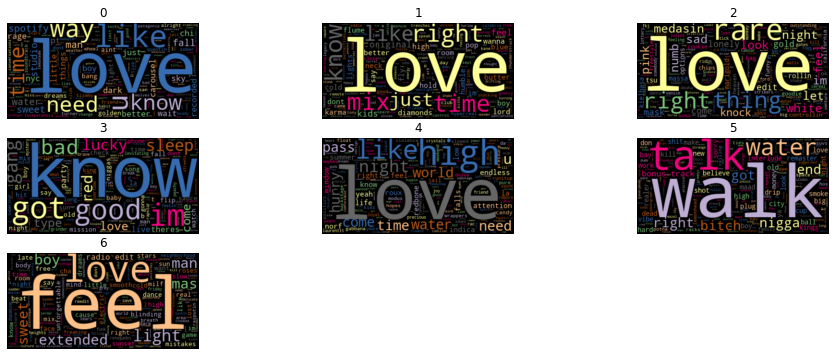

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[16,6]

for index,cluster in enumerate(songStringDF.transpose().columns):
    wc.generate(data_clean.songNamesString[cluster])
    
    plt.subplot(3,3,index+1)
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')
    plt.title(cluster)

plt.show()